<a href="https://colab.research.google.com/github/javier-jaime/Tool-Crib/blob/master/Colab%5CMontecarlo_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Estimate the decimals of π

Suppose you are randomly throwing darts at a square board of dimension 2x2 with an inner circle of radius 1.
The surface of the board is 4, the surface of the circle is π, so the probability to land in the circle (assuming all darts land on the board) is p=π/4.

In [1]:
# Function to estimate the probability to land in the circle
import random 
import math 
def estimate_p(m): 
    count = 0     
    # repeat m times 
    for _ in range(m): 
        # pick horizontal and vertical coordinates 
        x = random.random() 
        y = random.random()         
        # in the circle? 
        if x ** 2 + y ** 2 < 1: 
            count += 1             
    # return fraction of success 
    return count / m 

In [2]:
# Function to estimate π (by The Strong Law of Large Numbers)
def estimate_pi(m): 
    p = estimate_p(m) 
    # estimate of the standard error (by Central Limit Theorem)
    std = math.sqrt(p * (1-p) / m) 
    # answer 
    print("pi =", 4*p, "+/-", 4*std) 

In [3]:
# To estimate π correctly to the 4th decimal, you will need more than 10m
estimate_pi(1000)
estimate_pi(10000) 
estimate_pi(100000)
estimate_pi(10000000)    

pi = 3.176 +/- 0.0511568568229128
pi = 3.1604 +/- 0.016289480777483364
pi = 3.14208 +/- 0.0051919680985152445
pi = 3.1411476 +/- 0.0005194017861939098


In [4]:
# run the computation on GPU (Runtime) with TensorFlow v.1
%tensorflow_version 1.x
import tensorflow as tf 
def estimate_p_tf(m): 
	# random numbers 
	xs = tf.random.uniform([m]) 
	ys = tf.random.uniform([m]) 
	# square distances from origin 
	r = xs **2 + ys **2 
	# result 
	return tf.size(tf.where(r < 1.0)) / m 

def estimate_pi_tf(m): 
  p_ = estimate_p_tf(m) 
  with tf.Session() as sess:
    p = sess.run(p_)
    std = math.sqrt(p * (1-p) / m) 
  print("pi =", 4*p, "+/-", 4*std) 

TensorFlow 1.x selected.


In [10]:
# You can estimate π correctly to the 4th decimal in a fraction of a second
%%time
estimate_pi_tf(10000000)  

pi = 3.1415172 +/- 0.0005193205640165004
CPU times: user 367 ms, sys: 2.87 ms, total: 370 ms
Wall time: 309 ms


In [8]:
# The Monte-Carlo estimate of the call price with NumPy
# (the average payoff over your m simulations)
import numpy as np 
def estimate_call_price(m, spot, volatility, strike, maturity): 
	result = 0.0 
	std = np.sqrt(maturity) 
	drift = 0.5 * volatility ** 2 * maturity 
	# repeat m times 
	for _ in range(m): 
		# sample Brownian 
		WT = np.random.normal(0.0, std) 
		# final spot price 
		ST = spot * np.exp(- drift + volatility * WT) 
		# payoff 
		result += np.maximum(0.0, ST - strike) 
	# return estimate of expectation/price = average payoff 
	return result / m 

In [13]:
%%time
estimate_call_price(100000, 100, 0.2,  110, 2)

CPU times: user 677 ms, sys: 735 µs, total: 678 ms
Wall time: 681 ms


7.484448393715921

In [14]:
# The Monte-Carlo estimate of the call price with TensorFlow
%tensorflow_version 1.x
def estimate_call_price_tf(m, spot, volatility, strike, maturity): 
    std = tf.sqrt(maturity) 
    drift = 0.5 * volatility ** 2 * maturity 
    # Sample m Brownians 
    WTs = tf.random.normal([m], 0.0, std) 
    # Compute the m spots 
    STs = spot * tf.exp(- drift + volatility * WTs) 
    # Compute the m payoffs 
    payoffs = tf.maximum(0.0, STs - strike) 
    # Compute the average 
    result = tf.reduce_mean(payoffs) 
    # Do the computation on GPU 
    with tf.Session() as sess: 
        call = sess.run(result) 
	# result 
    return call 

## Pricing Exotic Options with Monte Carlo in TensorFlow

In [19]:
import numpy as np
import tensorflow as tf
import scipy.stats as stats
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [20]:
# Plain Vanilla Call in TF
def blackScholes_py(S_0, strike, time_to_expiry, implied_vol, riskfree_rate):
    S = S_0
    K = strike
    dt = time_to_expiry
    sigma = implied_vol
    r = riskfree_rate
    Phi = stats.norm.cdf
    d_1 = (np.log(S_0 / K) + (r+sigma**2/2)*dt) / (sigma*np.sqrt(dt))
    d_2 = d_1 - sigma*np.sqrt(dt)
    return S*Phi(d_1) - K*np.exp(-r*dt)*Phi(d_2)
 

In [21]:
%%time
blackScholes_py(100., 110., 2., 0.2, 0.03)

CPU times: user 722 µs, sys: 994 µs, total: 1.72 ms
Wall time: 1.59 ms


9.73983632580859

In [22]:
# Same BSM formula with function closure
def blackScholes_tf_pricer(enable_greeks = True):
    # Build the static computational graph
    S = tf.placeholder(tf.float32)
    K = tf.placeholder(tf.float32)
    dt = tf.placeholder(tf.float32)
    sigma = tf.placeholder(tf.float32)
    r = tf.placeholder(tf.float32)
    Phi = tf.distributions.Normal(0.,1.).cdf
    d_1 = (tf.log(S / K) + (r+sigma**2/2)*dt) / (sigma*tf.sqrt(dt))
    d_2 = d_1 - sigma*tf.sqrt(dt)
    npv =  S*Phi(d_1) - K*tf.exp(-r*dt)*Phi(d_2)
    target_calc = [npv]
    if enable_greeks:
        greeks = tf.gradients(npv, [S, sigma, r, K, dt])
        dS_2ndOrder = tf.gradients(greeks[0], [S, sigma, r, K, dt]) 
        # Calculate mixed 2nd order greeks for S (esp. gamma, vanna) and sigma (esp. volga)
        dsigma_2ndOrder = tf.gradients(greeks[1], [S, sigma, r, K, dt])
        dr_2ndOrder = tf.gradients(greeks[2], [S, sigma, r, K, dt]) 
        dK_2ndOrder = tf.gradients(greeks[3], [S, sigma, r, K, dt]) 
        dT_2ndOrder = tf.gradients(greeks[4], [S, sigma, r, K, dt])
        target_calc += [greeks, dS_2ndOrder, dsigma_2ndOrder, dr_2ndOrder, dK_2ndOrder, dT_2ndOrder]
     
    # Function to feed in the input and calculate the computational graph
    def execute_graph(S_0, strike, time_to_expiry, implied_vol, riskfree_rate):
        with tf.Session() as sess:
            res = sess.run(target_calc, 
                           {
                               S: S_0,
                               K : strike,
                               r : riskfree_rate,
                               sigma: implied_vol,
                               dt: time_to_expiry})
        return res
    return execute_graph
 
tf_pricer = blackScholes_tf_pricer()
tf_pricer(100., 110., 2., 0.2, 0.03)

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


[9.739834,
 [0.5066145, 56.411205, 81.843216, -0.37201464, 4.0482087],
 [0.014102802, 0.5310427, 2.8205605, -0.012820729, 0.06886054],
 [0.5310427, -1.2452297, -6.613867, 0.030063031, 13.941332],
 [2.8205605, -6.613866, 400.42563, -1.8201164, 46.597298],
 [-0.012820728, 0.030063028, -1.8201163, 0.011655207, -0.025798593],
 [0.06886053, 13.941331, 46.597298, -0.025798589, -0.62807804]]

In [23]:
# The function will return the operator to calculate the random price paths and the placeholder
def create_tf_graph_for_simulate_paths():
    S = tf.placeholder(tf.float32)
    K = tf.placeholder(tf.float32)
    dt = tf.placeholder(tf.float32)
    T = tf.placeholder(tf.float32)
    sigma = tf.placeholder(tf.float32)
    r = tf.placeholder(tf.float32)
    dw = tf.placeholder(tf.float32)
    S_T = S * tf.cumprod(tf.exp((r-sigma**2/2)*dt+sigma*tf.sqrt(dt)*dw), axis=1)
    return (S, K, dt, T, sigma, r, dw, S_T)

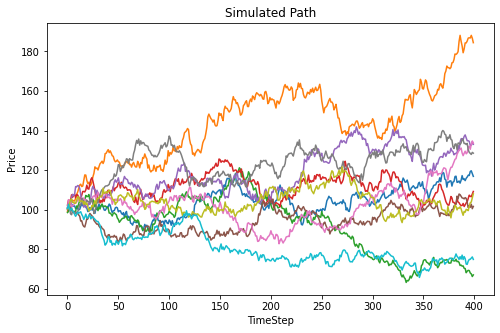

In [24]:
# To test the function we create another function
def make_path_simulator():
    (S,K, dt, T, sigma, r, dw, S_T) = create_tf_graph_for_simulate_paths()
    def paths(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, seed, n_sims, obs):
        if seed != 0:
            np.random.seed(seed)
        stdnorm_random_variates = np.random.randn(n_sims, obs)
        with tf.Session() as sess:
            timedelta = time_to_expiry / stdnorm_random_variates.shape[1]
            res = sess.run(S_T, 
                           {
                               S: S_0,
                               K : strike,
                               r : riskfree_rate,
                               sigma: implied_vol,
                               dt : timedelta,
                               T: time_to_expiry,
                               dw : stdnorm_random_variates
                         })
            return res
    return paths
 
path_simulator = make_path_simulator()
paths = path_simulator(100, 110.,  2, 0.2, 0.03, 1312, 10, 400)
plt.figure(figsize=(8,5))
_= plt.plot(np.transpose(paths))
_ = plt.title('Simulated Path')
_ = plt.ylabel('Price')
_ = plt.xlabel('TimeStep') 

In [25]:
# This function will create the computational graph and returns a function that generates the random numbers, feed our parameter into the graph and run it.
def create_plain_vanilla_mc_tf_pricer(enable_greeks = True):
    (S,K, dt, T, sigma, r, dw, S_T) = create_tf_graph_for_simulate_paths()
    payout = tf.maximum(S_T[:,-1] - K, 0)
    npv = tf.exp(-r*T) * tf.reduce_mean(payout)
    target_calc = [npv]
    if enable_greeks:
        greeks = tf.gradients(npv, [S, sigma, r, K, T])
        target_calc += [greeks]
    def pricer(S_0, strike, time_to_expiry, implied_vol, riskfree_rate, seed, n_sims):
        if seed != 0:
            np.random.seed(seed)
        stdnorm_random_variates = np.random.randn(n_sims, 1)
        with tf.Session() as sess:
            timedelta = time_to_expiry / stdnorm_random_variates.shape[1]
            res = sess.run(target_calc, 
                           {
                               S: S_0,
                               K : strike,
                               r : riskfree_rate,
                               sigma: implied_vol,
                               dt : timedelta,
                               T: time_to_expiry,
                               dw : stdnorm_random_variates
                         })
            return res
    return pricer
 
plain_vanilla_mc_tf_pricer = create_plain_vanilla_mc_tf_pricer()
plain_vanilla_mc_tf_pricer(100, 110, 2, 0.2, 0.03, 1312, 1000000)

[9.734384, [0.50598943, 56.385994, 81.72911, -0.37149754, -0.2920315]]

In [26]:
%%timeit
plain_vanilla_mc_tf_pricer(100, 110, 2, 0.2, 0.03, 1312, 1000000)

%timeit
plain_vanilla_mc_tf_pricer(100, 110, 2, 0.2, 0.03, 1312, 1000000)



1 loop, best of 5: 754 ms per loop


In [27]:
%%timeit
plain_vanilla_mc_tf_pricer(100, 110, 2, 0.2, 0.03, 1312, 1000000)

1 loop, best of 5: 374 ms per loop


## low level TensorFlow framework to solve simple integration problems

As an example problem, let’s find the solution of the following equation:

$\int_{0}^{2}{x^{2}}dx$

This can easily be integrated to obtain:

$\tfrac{x^{3}}{3}\big|_0^2 = 2.667$

Now if want to solve it using Monte Carlo simulation, we have to generate random samples within some bounded region and see how many of those fall within our region of interest i.e. lie under the line drawn by y=x2.

In [28]:
# Function to compute the integral
def compute_integral(n_samples):
    # Generate Samples
    x = tf.random_uniform((n_samples,1),0,2)
    y = tf.random_uniform((n_samples,1),0,4)
    # Find region of interest
    c_in_region = y<x**2
    # Find the total count of these samples
    count = tf.reduce_sum(tf.cast(c_in_region,tf.int16))
    # Compute the area
    return count*8/n_samples

In [29]:
# Using TensorFlow session
with tf.Session() as sess:
    result = sess.run(compute_integral(10000))
    print(result)

2.6824
